Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Training with LR=0.001, Optimizer=adam, Batch Size=32


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1: Train Acc=84.12%, Train Loss=1.4897, Val Loss=0.5440, Val Acc=93.41%
Epoch 2: Train Acc=95.30%, Train Loss=0.2759, Val Loss=0.6957, Val Acc=91.21%
Epoch 3: Train Acc=98.76%, Train Loss=0.1015, Val Loss=0.5356, Val Acc=92.31%

Training with LR=0.001, Optimizer=adam, Batch Size=64
Epoch 1: Train Acc=81.63%, Train Loss=1.0770, Val Loss=0.4079, Val Acc=86.81%
Epoch 2: Train Acc=96.13%, Train Loss=0.1870, Val Loss=0.1612, Val Acc=94.51%
Epoch 3: Train Acc=98.07%, Train Loss=0.0630, Val Loss=0.1220, Val Acc=94.51%

Training with LR=0.001, Optimizer=sgd, Batch Size=32
Epoch 1: Train Acc=84.39%, Train Loss=0.3560, Val Loss=0.1845, Val Acc=92.31%
Epoch 2: Train Acc=95.58%, Train Loss=0.1231, Val Loss=0.1338, Val Acc=94.51%
Epoch 3: Train Acc=97.24%, Train Loss=0.0799, Val Loss=0.1151, Val Acc=94.51%

Training with LR=0.001, Optimizer=sgd, Batch Size=64
Epoch 1: Train Acc=74.17%, Train Loss=0.4973, Val Loss=0.2846, Val Acc=90.11%
Epoch 2: Train Acc=92.68%, Train Loss=0.1850, Val Loss=0.

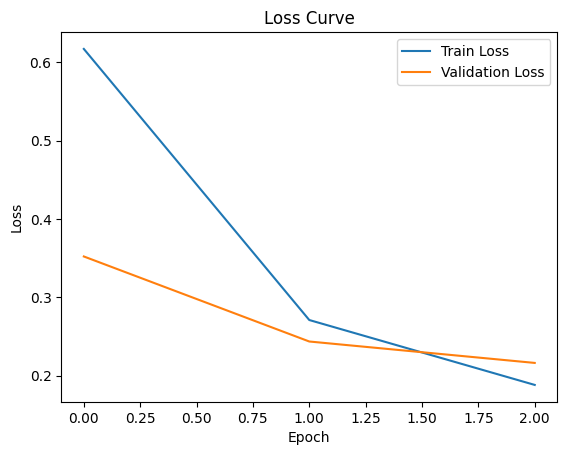

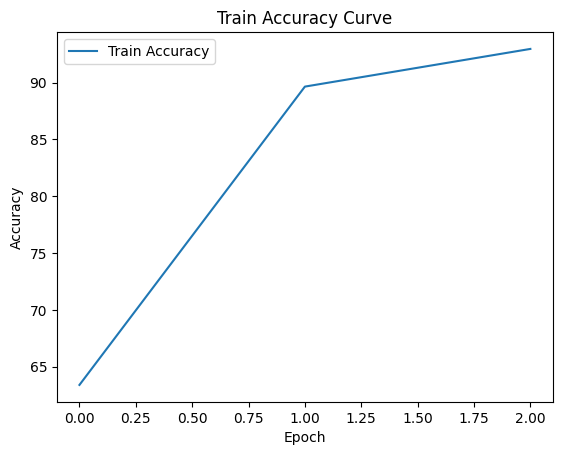


=== Hyperparameter Tuning Summary ===
LR: 0.001, Optimizer: adam, Batch Size: 32, Val Accuracy: 92.31%, Train Accuracy: 98.76%
LR: 0.001, Optimizer: adam, Batch Size: 64, Val Accuracy: 94.51%, Train Accuracy: 98.07%
LR: 0.001, Optimizer: sgd, Batch Size: 32, Val Accuracy: 94.51%, Train Accuracy: 97.24%
LR: 0.001, Optimizer: sgd, Batch Size: 64, Val Accuracy: 93.41%, Train Accuracy: 95.58%
LR: 0.0005, Optimizer: adam, Batch Size: 32, Val Accuracy: 92.31%, Train Accuracy: 97.65%
LR: 0.0005, Optimizer: adam, Batch Size: 64, Val Accuracy: 96.70%, Train Accuracy: 99.03%
LR: 0.0005, Optimizer: sgd, Batch Size: 32, Val Accuracy: 93.41%, Train Accuracy: 95.17%
LR: 0.0005, Optimizer: sgd, Batch Size: 64, Val Accuracy: 90.11%, Train Accuracy: 92.96%

Test Accuracy: 95.56%

📊 Final Test Performance:
✔ Precision: 0.96
✔ Recall: 0.96
✔ F1 Score: 0.96
✔ ROC-AUC: 1.00

Classification Report:
                 precision    recall  f1-score   support

    Degradable       0.94      0.98      0.96      

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


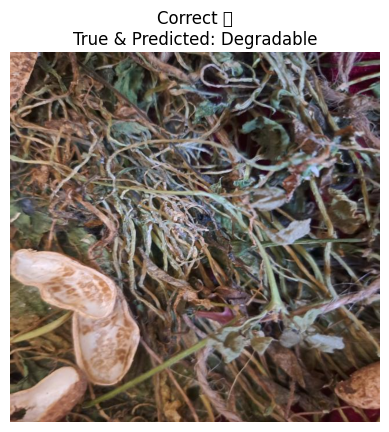

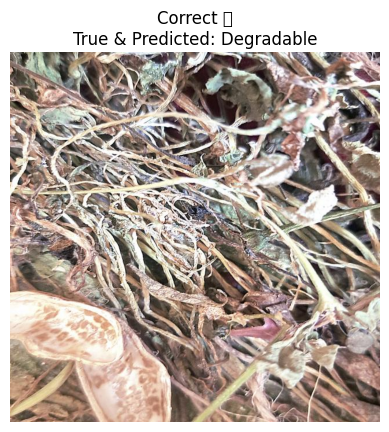

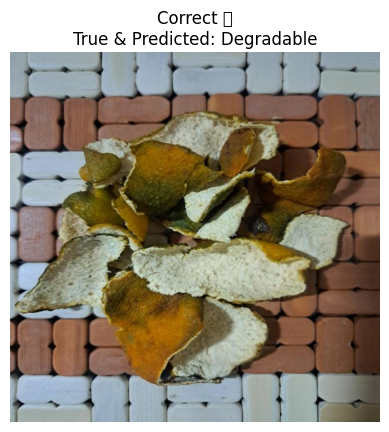

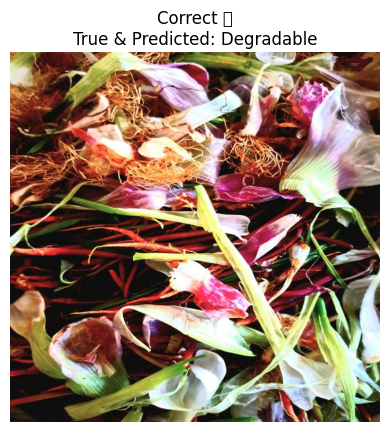

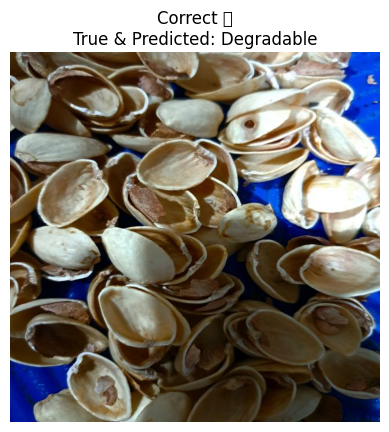

In [1]:
# Mount Google Drive and set paths
from google.colab import drive
drive.mount('/content/drive')

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score
from torchinfo import summary
from ptflops import get_model_complexity_info
import platform
import time
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from itertools import product
import random

# Set dataset path
data_dir = '/content/drive/MyDrive/dataset'

# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dir = os.path.join(data_dir, 'train')
valid_dir = os.path.join(data_dir, 'valid')
test_dir = os.path.join(data_dir, 'test')

train_data = datasets.ImageFolder(train_dir, transform=transform)
valid_data = datasets.ImageFolder(valid_dir, transform=transform)
test_data = datasets.ImageFolder(test_dir, transform=transform)

# Hyperparameter tuning configs
learning_rates = [0.001, 0.0005]
optimizers = ['adam', 'sgd']
batch_sizes = [32, 64]
epochs = 3

best_model = None
best_val_accuracy = 0
results = []
train_time = None
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for lr, opt_type, batch_size in product(learning_rates, optimizers, batch_sizes):
    print(f"\nTraining with LR={lr}, Optimizer={opt_type}, Batch Size={batch_size}")

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_data, batch_size=batch_size)

    model = models.vgg19(pretrained=True)
    for param in model.features.parameters():
        param.requires_grad = False
    model.classifier[6] = nn.Linear(4096, 2)
    model = model.to(device)

    optimizer = optim.Adam(model.classifier.parameters(), lr=lr) if opt_type == 'adam' else optim.SGD(model.classifier.parameters(), lr=lr, momentum=0.9)
    criterion = nn.CrossEntropyLoss()

    train_losses, val_losses = [], []
    train_accuracies = []
    start_time = time.time()

    best_val_loss = float('inf')
    early_stop_counter = 0
    patience = 2

    for epoch in range(epochs):
        model.train()
        train_loss, correct_train, total_train = 0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        train_accuracy = 100 * correct_train / total_train
        train_accuracies.append(train_accuracy)

        model.eval()
        val_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        avg_val_loss = val_loss / len(valid_loader)
        val_losses.append(avg_val_loss)
        val_accuracy = 100 * correct / total

        print(f"Epoch {epoch+1}: Train Acc={train_accuracy:.2f}%, Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}, Val Acc={val_accuracy:.2f}%")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print("Early stopping triggered.")
                break

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model = model

    train_time = time.time() - start_time
    results.append((lr, opt_type, batch_size, val_accuracy, train_accuracy))

# Plot Loss Curve
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

# Plot Accuracy Curve
plt.plot(train_accuracies, label='Train Accuracy')
plt.title("Train Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

print("\n=== Hyperparameter Tuning Summary ===")
for r in results:
    print(f"LR: {r[0]}, Optimizer: {r[1]}, Batch Size: {r[2]}, Val Accuracy: {r[3]:.2f}%, Train Accuracy: {r[4]:.2f}%")

# ---------- Final Evaluation on Test Set ---------- #
model = best_model
model.eval()
correct, total = 0, 0
all_preds, all_labels, all_probs = [], [], []
start_test_time = time.time()

with torch.no_grad():
    for inputs, labels in DataLoader(test_data, batch_size=32):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        _, predicted = probs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs[:, 1].cpu().numpy())

print(f"\nTest Accuracy: {100 * correct / total:.2f}%")

# ---------- Metrics ---------- #
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')
roc_auc = roc_auc_score(all_labels, all_probs)

print("\n📊 Final Test Performance:")
print(f"✔ Precision: {precision:.2f}")
print(f"✔ Recall: {recall:.2f}")
print(f"✔ F1 Score: {f1:.2f}")
print(f"✔ ROC-AUC: {roc_auc:.2f}")

print("\nClassification Report:\n", classification_report(all_labels, all_preds, target_names=train_data.classes))
print("Confusion Matrix:\n", confusion_matrix(all_labels, all_preds))

# ---------- Computational Parameters ---------- #
print("\n--- Model Info ---")
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total Parameters: {total_params}")
print(f"Trainable Parameters: {trainable_params}")

summary(model, input_size=(1, 3, 224, 224))
with torch.cuda.device(0):
    macs, params = get_model_complexity_info(model, (3, 224, 224), as_strings=True, print_per_layer_stat=False)
    print(f"FLOPs: {macs}, Params: {params}")

print("Training Platform:", platform.platform())
print("CUDA Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")
print(f"Total Training Time: {train_time:.2f} seconds")
print(f"Inference Time on 1 image: {time.time() - start_test_time:.4f} seconds")

# ---------- Robustness Test (Noise and Lighting) ---------- #
transform_robust = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.5),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x + 0.05 * torch.randn_like(x)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
robust_data = datasets.ImageFolder(test_dir, transform=transform_robust)
robust_loader = DataLoader(robust_data, batch_size=32)

correct, total = 0, 0
with torch.no_grad():
    for inputs, labels in robust_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Robustness (Noise & Lighting) Accuracy: {100 * correct / total:.2f}%")

# ---------- Visualization of Correct Predictions ---------- #
correct_preds = [(img[0], p, l) for img, p, l in zip(test_data.imgs, all_preds, all_labels) if p == l]

for i in range(min(5, len(correct_preds))):
    path, pred, label = correct_preds[i]
    img = Image.open(path)
    plt.imshow(img)
    plt.title(f"Correct ✅\nTrue & Predicted: {train_data.classes[pred]}")
    plt.axis('off')
    plt.show()

# ---------- Save Model ---------- #
torch.save(model.state_dict(), '/content/drive/MyDrive/vgg19_best_model.pth')


In [2]:
!pip install torchinfo

In [3]:
!pip install ptflops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 64.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 33.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin